In [12]:
import skysurvey
import matplotlib.pyplot as plt
import numpy as np
import sncosmo
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
import corner
import pandas

In [13]:
import warnings
from iminuit.warnings import IMinuitWarning
warnings.filterwarnings('ignore', category=IMinuitWarning) 

# skysurvey tests

In [2]:
snia = skysurvey.SNeIa()

In [3]:
data = snia.draw(size=10_000, inplace=True)

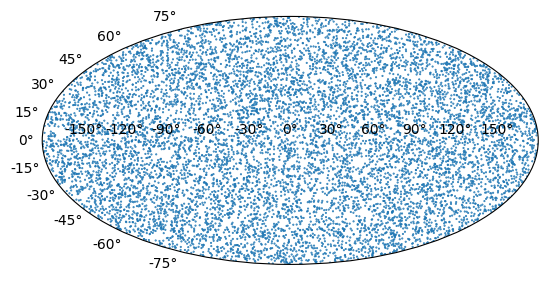

In [4]:
fig = plt.figure()
ax = fig.add_subplot(projection="mollweide")
ax.scatter(
    (snia.data["ra"] - 360 * (snia.data["ra"] > 180)) * np.pi / 180,
    snia.data["dec"] * np.pi / 180,
    linestyle="",
    marker=".",
    s=1,
)

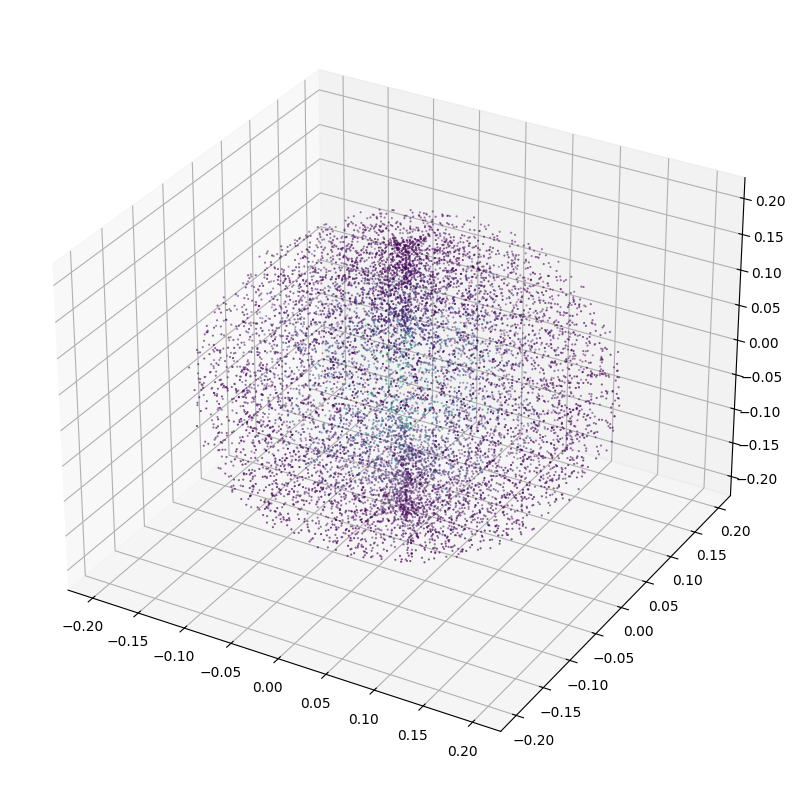

In [5]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="3d"))

count, bin = np.histogramdd([snia.data["ra"], snia.data["dec"], snia.data["z"]], bins=50)
count = gaussian_filter(count, 0.9)
binra, bindec, binz = bin
x, y, z = np.meshgrid(
    (binra[:-1] + binra[1:]) / 2 - binra.min(),
    (bindec[:-1] + bindec[1:]) / 2 - bindec.min(),
    (binz[:-1] + binz[1:]) / 2 - binz.min(),
)
tree = cKDTree(np.dstack((x.flatten(), y.flatten(), z.flatten())).reshape(-1, 3))
pts = np.vstack(
    [snia.data["ra"] - binra.min(), snia.data["dec"] - bindec.min(), snia.data["z"] - binz.min()]
).T


def density_tree(
    pts: np.ndarray, tree: cKDTree, density: np.ndarray, k=1
) -> np.ndarray:
    dist_id, nn_id = tree.query(pts, k=k)
    try:
        density = np.average(density[nn_id], axis=1, weights=1 / dist_id)
    except np.AxisError:
        density = density[nn_id]
    return density


c = density_tree(
    pts, tree, np.transpose(count, axes=[1, 0, 2]).flatten()[::-1], k=1
)

ax.scatter(
    np.cos(snia.data["ra"]) * np.sin(snia.data["dec"]) * snia.data["z"],
    np.sin(snia.data["ra"]) * np.sin(snia.data["dec"]) * snia.data["z"],
    np.cos(snia.data["dec"]) * snia.data["z"],
    s=1,
    c=c,
    marker=".",
)

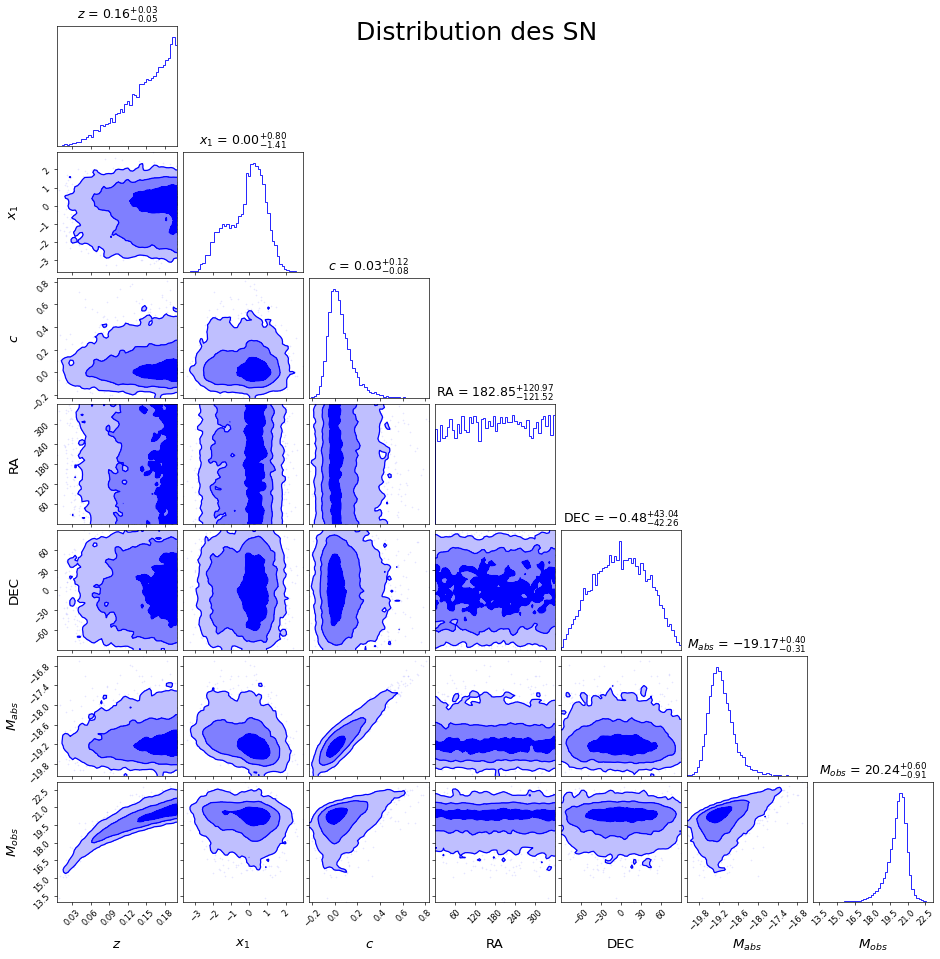

In [6]:
fig = corner.corner(
    snia.data,
    var_names=["z", "x1", "c", "ra", "dec", "magabs", "magobs"],
    show_titles=True,
    bins=50,
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=15),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=[r"$z$", r"$x_1$", r"$c$", r"RA", r"DEC", r"$M_{abs}$", r"$M_{obs}$"],
    alpha=0.2,
)

fig.suptitle('Distribution des SN', fontsize=30)
fig.set_dpi(60)

In [77]:
# footprint
from shapely import geometry

footprint = geometry.Point(0, 0).buffer(2)

# observing logs
from skysurvey.tools import utils

size = 10_000

data = {}
data["gain"] = 1
data["zp"] = 30
data["skynoise"] = np.random.normal(size=size, loc=200, scale=20)
data["mjd"] = np.random.uniform(56_000, 56_200, size=size)
data["band"] = np.random.choice(["ztfg", "ztfr", "ztfi"], size=size)

data["ra"], data["dec"] = utils.random_radec(
    size=size, ra_range=[200, 250], dec_range=[-20, 10]
)

# Load a GridSurvey
survey = skysurvey.Survey.from_pointings(data, footprint=footprint)

In [78]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:751: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  this_survey = gsurvey_indexed.get_group(index_).copy()
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:154: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  data = pandas.concat(lightcurves, keys=fieldids # store fieldid


In [128]:
dataset = dset.get_ndetection() > 5
detected = dataset[dataset].index

In [130]:
len(detected)

360

Text(0.5, 0.98, 'Distribution des SN détectées')

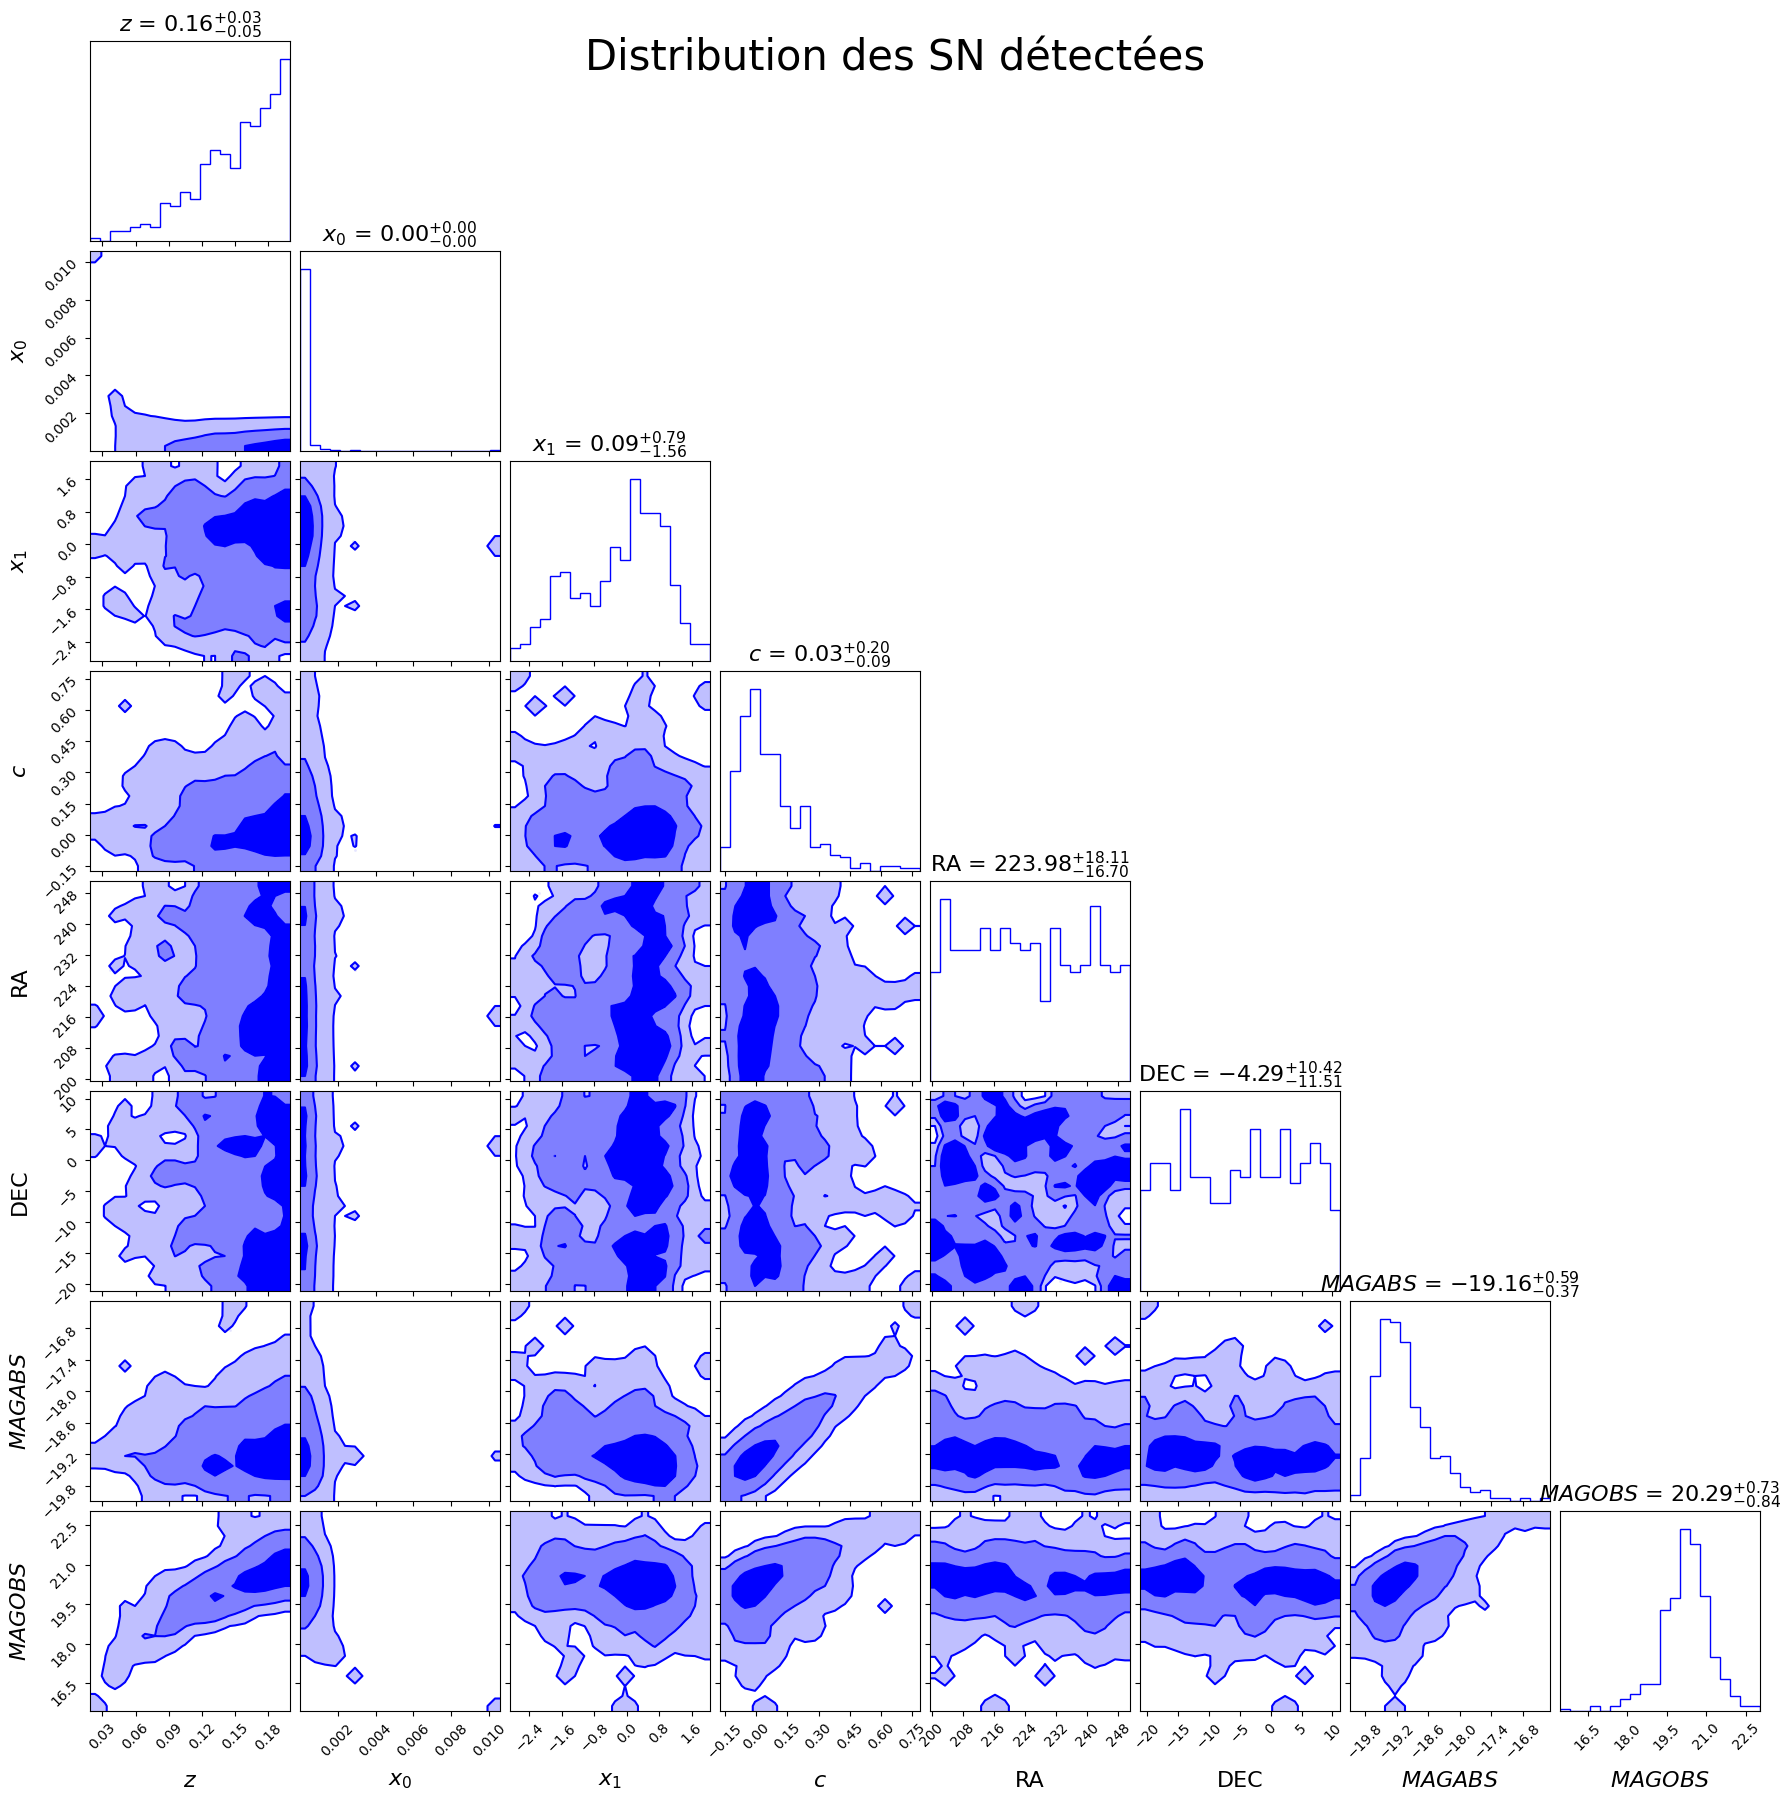

In [81]:
fig = corner.corner(
    dset.targets.data.loc[detected],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    show_titles=True,
    bins=20,
    smooth=0.9,
    quantiles=None,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=[
        r"$z$",
        r"$x_0$",
        r"$x_1$",
        r"$c$",
        r"RA",
        r"DEC",
        r"$MAGABS$",
        r"$MAGOBS$",
    ],
    alpha=0.2,
)
fig.suptitle('Distribution des SN détectées', fontsize=30)

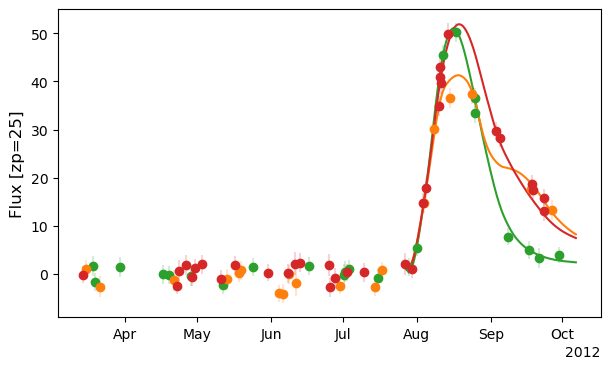

In [18]:
_ = dset.show_target_lightcurve(index=detected[212])

In [85]:
fixed = {"z": dset.targets.data.loc[detected]["z"]}

guess = {
    "t0": dset.targets.data.loc[detected]["t0"],
    "c": dset.targets.data.loc[detected]["c"],
    "x0": dset.targets.data.loc[detected]["x0"],
    "x1": dset.targets.data.loc[detected]["x1"],
}
bounds = {
    "t0": dset.targets.data.loc[detected]["t0"].apply(lambda x: [x-5, x+5]),
    "c": dset.targets.data.loc[detected]["c"].apply(lambda x: [-0.3, 1.0]),
    "x0": dset.targets.data.loc[detected]["x0"].apply(lambda x: [0, 0.1]),
    "x1": dset.targets.data.loc[detected]["x1"].apply(lambda x: [-4, 4]),
}

results, meta = dset.fit_lightcurves(
    source=sncosmo.Model("salt2"),
    index=detected,
    use_dask=False,
    fixedparams=fixed,
    guessparams=guess,
    bounds=bounds,
)

In [87]:
results

value     error        cov_t0        cov_x0        cov_x1  \
index                                                                        
61    z       0.165950       NaN           NaN           NaN           NaN   
      t0  56076.642355  0.000119  1.406037e-08 -8.320405e-15  3.406144e-10   
      x0      0.000141  0.000003 -8.320405e-15  8.518550e-12 -1.609167e-07   
      x1     -1.494876  0.173515  3.406144e-10 -1.609167e-07  3.012934e-02   
      c      -0.100651  0.016845  5.986491e-11 -4.064239e-08  7.499385e-04   
...                ...       ...           ...           ...           ...   
9976  z       0.175650       NaN           NaN           NaN           NaN   
      t0  56040.948513  0.020004  4.001741e-04  2.702059e-13 -1.271361e-08   
      x0      0.000044  0.000002  2.702059e-13  3.919417e-12 -2.269164e-07   
      x1     -0.518954  0.285869 -1.271361e-08 -2.269164e-07  8.186272e-02   
      c       0.366539  0.031626 -4.540617e-09 -5.675693e-08  2.304500e-03   

                 cov_c         truth  
index                                 
61    z            NaN       0.16595  
      t0  5.986491e-11  56075.347656  
      x0 -4.064239e-08       0.00014  
      x1  7.499385e-04         -1.77  
      c   2.838648e-04     -0.111124  
...                ...           ...  
9976  z            NaN       0.17565  
      t0 -4.540617e-09  56040.851562  
      x0 -5.675693e-08      0.000045  
      x1  2.304500e-03        -0.195  
      c   1.001014e-03      0.343443  

[1800 rows x 7 columns]

In [88]:
better_results = pandas.DataFrame(
    {
        col: np.array(results["value"].loc[map(lambda x: (x, col), detected)]-results["truth"].loc[map(lambda x: (x, col), detected)])
        for col in guess.keys()
    }
)

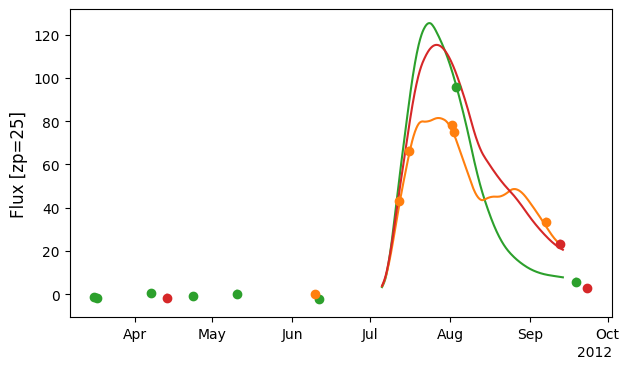

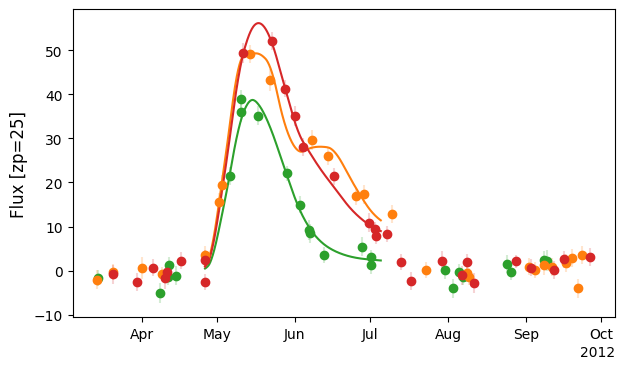

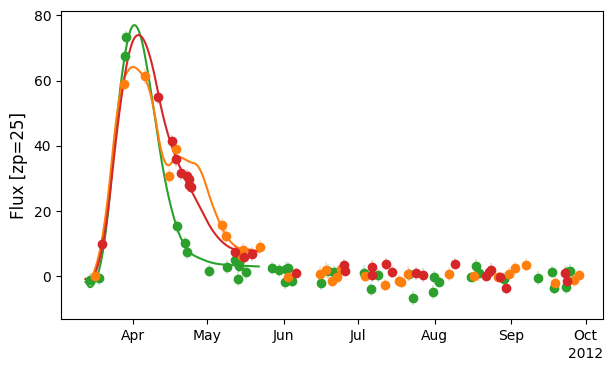

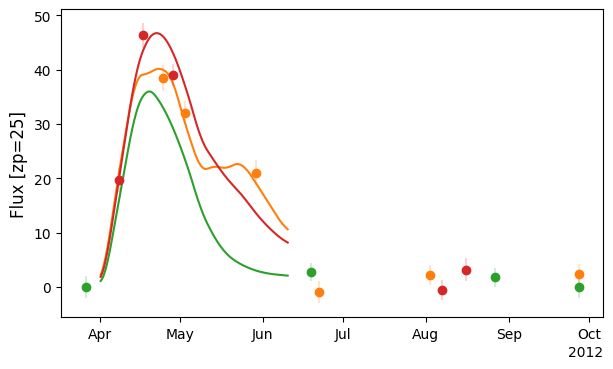

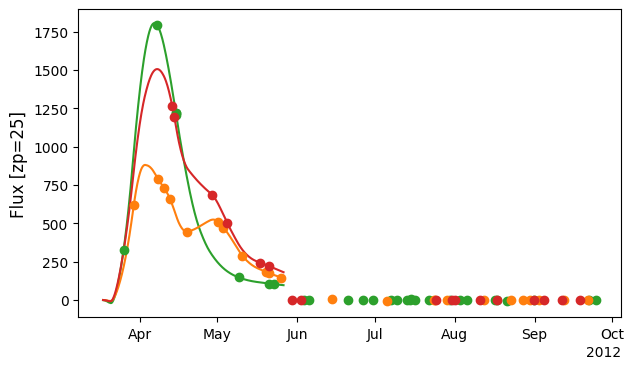

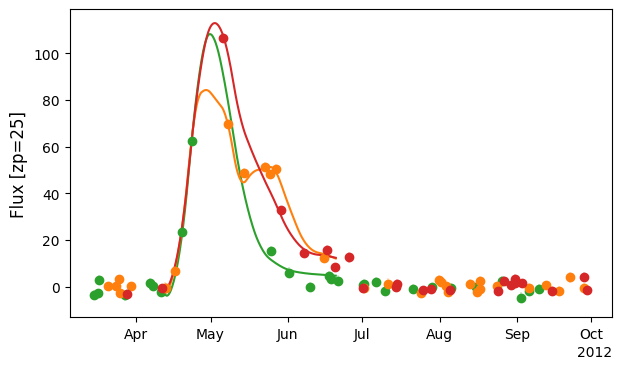

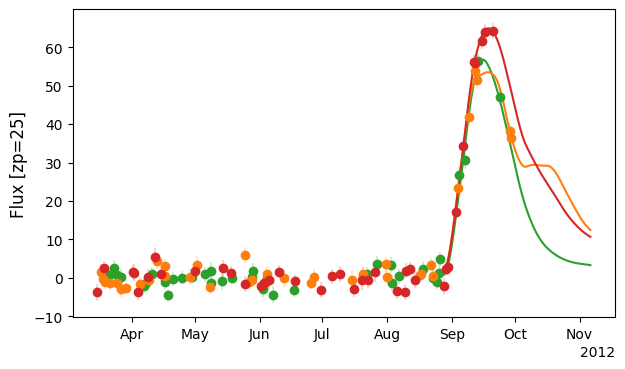

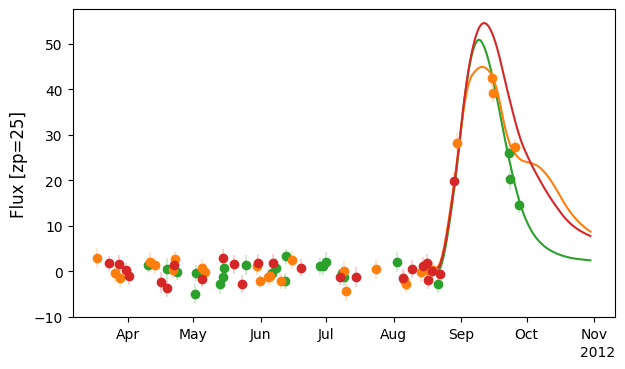

In [89]:
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["t0"]==better_results['t0'].max()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["t0"]==better_results['t0'].min()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["c"]==better_results['c'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["c"]==better_results['c'].max()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x0"]==better_results['x0'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x0"]==better_results['x0'].max()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x1"]==better_results['x1'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x1"]==better_results['x1'].max()].index[0]])

Text(0.5, 0.98, 'Erreur absolue sur les paramètres reconstruits')

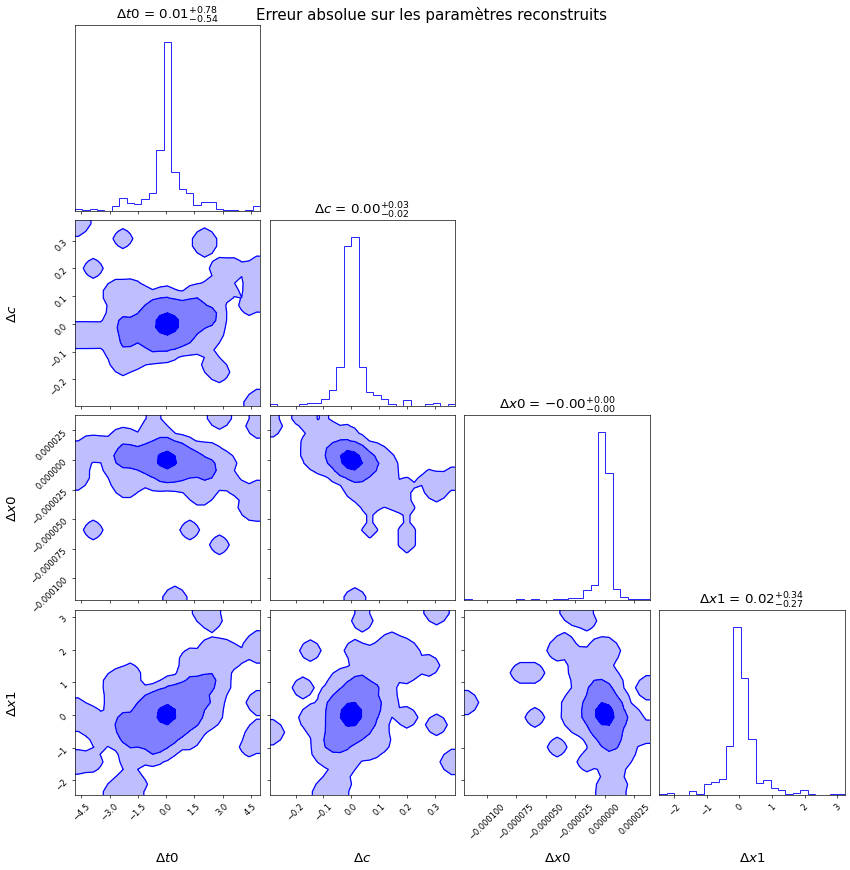

In [158]:
fig = plt.figure(figsize=(15,15),dpi=60)
_ = corner.corner(
    better_results,
    fig=fig,
    var_names=list(guess.keys()),
    show_titles=True,
    bins=25,
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=list(map(lambda x : r"$\Delta "+x+r"$", guess.keys())),
    alpha=0.2,
)
fig.suptitle('Erreur absolue sur les paramètres reconstruits', fontsize=18)

# Uchuu tests

In [1]:
from skysurvey_desi import *

In [44]:
bgs_df = load_bgs()

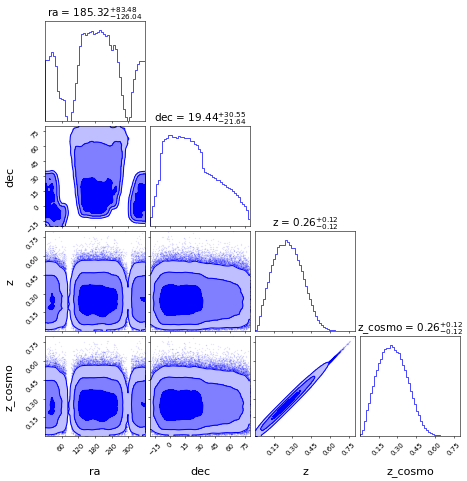

In [45]:
_=corner_(bgs_df[bgs_df['in_desi']][::50], var_names=['ra','dec','z','z_cosmo'])

Text(0, 0.5, 'Dec (deg)')

<Figure size 640x480 with 0 Axes>

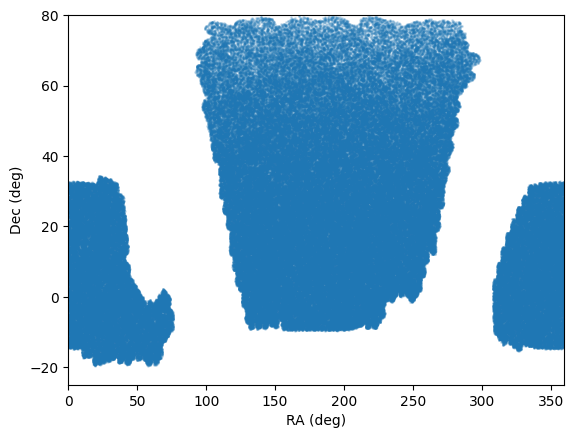

In [46]:
plt.figure()
bgs_df[bgs_df['in_desi']][::100].plot.scatter('ra', 'dec', s=1, edgecolor=None, alpha=0.2)
plt.xlim(0,360)
plt.ylim(-25, 80)
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")

In [12]:
snia = skysurvey.SNeIa()
data = snia.draw(size=10000, inplace=True)

In [14]:
snia.data['ra'] = bgs_df[bgs_df['in_desi']].reset_index()['ra'][:10000]
snia.data['dec'] = bgs_df[bgs_df['in_desi']].reset_index()['dec'][:10000]
snia.data['z'] = bgs_df[bgs_df['in_desi']].reset_index()['z'][:10000]

In [40]:
np.random.choice(bgs_df[bgs_df['in_desi']].index, size=10000)

array([11593871,  5174248, 10686285, ..., 67243216, 10169474, 21903608])

In [5]:
snia = draw_SN(10000)

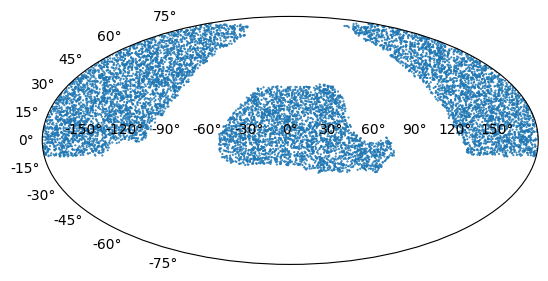

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection="mollweide")
ax.scatter(
    (snia.data["ra"] - 360 * (snia.data["ra"] > 180)) * np.pi / 180,
    snia.data["dec"] * np.pi / 180,
    linestyle="",
    marker=".",
    s=1,
)

In [7]:
# footprint
from shapely import geometry

footprint = geometry.Point(0, 0).buffer(2)

# observing logs
from skysurvey.tools import utils

size = 10_000

data = {}
data["gain"] = 1
data["zp"] = 30
data["skynoise"] = np.random.normal(size=size, loc=200, scale=20)
data["mjd"] = np.random.uniform(56_000, 56_200, size=size)
data["band"] = np.random.choice(["ztfg", "ztfr", "ztfi"], size=size)

data["ra"], data["dec"] = utils.random_radec(
    size=size, ra_range=[200, 250], dec_range=[-20, 10]
)

# Load a GridSurvey
survey = skysurvey.Survey.from_pointings(data, footprint=footprint)

In [8]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)
dataset = dset.get_ndetection() > 5
detected = dataset[dataset].index

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:755: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  this_survey = gsurvey_indexed.get_group(index_).copy()
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:154: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  data = pandas.concat(lightcurves, keys=fieldids # store fieldid


In [9]:
len(detected)

545

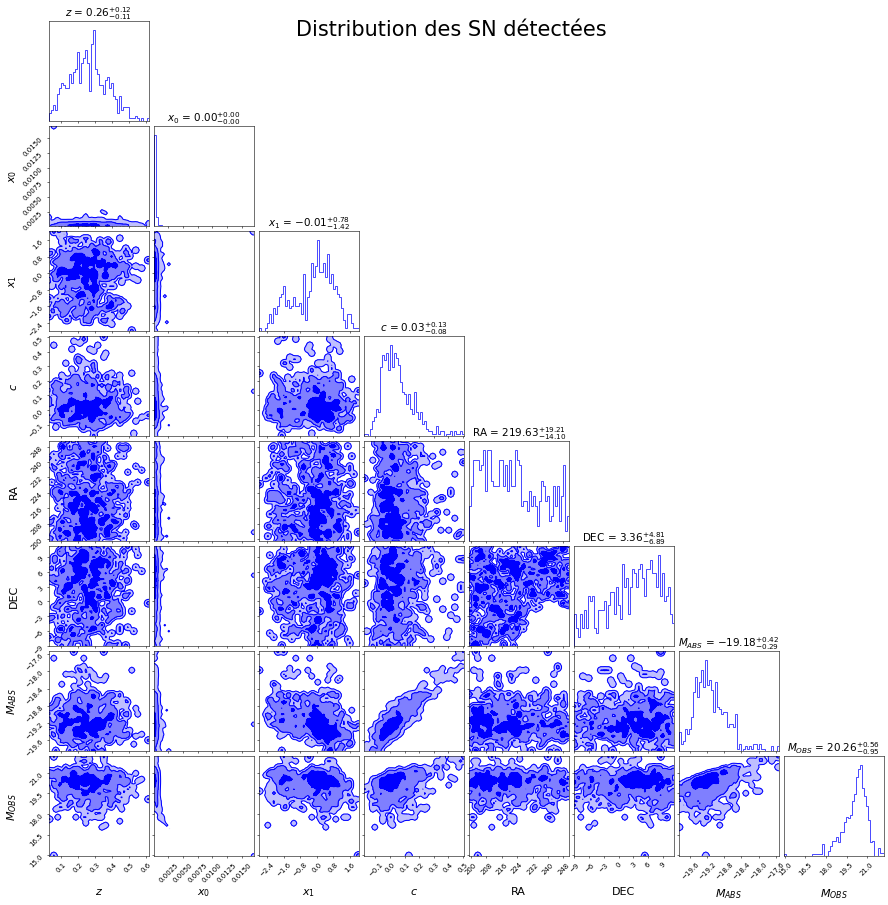

In [10]:
fig = corner_(dset.targets.data.loc[detected],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    labels=[
        r"$z$",
        r"$x_0$",
        r"$x_1$",
        r"$c$",
        r"RA",
        r"DEC",
        r"$M_{ABS}$",
        r"$M_{OBS}$",
    ], title='Distribution des SN détectées')


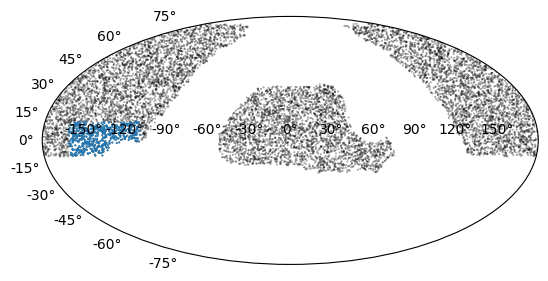

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection="mollweide")
ax.scatter(
    (dset.targets.data["ra"] - 360 * (dset.targets.data["ra"] > 180)) * np.pi / 180,
    dset.targets.data["dec"] * np.pi / 180,
    linestyle="",
    marker=".",
    s=0.5,
    c='k',
    alpha=0.5,
)
ax.scatter(
    (dset.targets.data.loc[detected]["ra"] - 360 * (dset.targets.data.loc[detected]["ra"] > 180)) * np.pi / 180,
    dset.targets.data.loc[detected]["dec"] * np.pi / 180,
    linestyle="",
    marker=".",
    s=1,
)
plt.savefig('../../../project/figures/Uchuu_scatter')

In [14]:
fixed = {"z": dset.targets.data.loc[detected]["z"]}

guess = {
    "t0": dset.targets.data.loc[detected]["t0"],
    "c": dset.targets.data.loc[detected]["c"],
    "x0": dset.targets.data.loc[detected]["x0"],
    "x1": dset.targets.data.loc[detected]["x1"],
}
bounds = {
    "t0": dset.targets.data.loc[detected]["t0"].apply(lambda x: [x-5, x+5]),
    "c": dset.targets.data.loc[detected]["c"].apply(lambda x: [-0.3, 1.0]),
    "x0": dset.targets.data.loc[detected]["x0"].apply(lambda x: [0, 0.1]),
    "x1": dset.targets.data.loc[detected]["x1"].apply(lambda x: [-4, 4]),
}

results, meta = dset.fit_lightcurves(
    source=sncosmo.Model("salt2"),
    index=detected,
    use_dask=False,
    fixedparams=fixed,
    guessparams=guess,
    bounds=bounds,
)

100%|██████████| 545/545 [01:59<00:00,  4.57it/s]


In [15]:
results

value     error        cov_t0        cov_x0        cov_x1  \
index                                                                        
0     z       0.153068       NaN           NaN           NaN           NaN   
      t0  56094.001346  0.003644  1.328091e-05  3.225549e-15 -1.440782e-09   
      x0      0.000063  0.000001  3.225549e-15  1.895530e-12 -2.091803e-07   
      x1      0.461841  0.254714 -1.440782e-09 -2.091803e-07  6.496807e-02   
      c       0.078333  0.019415  6.849575e-11 -1.615777e-08  1.427951e-03   
...                ...       ...           ...           ...           ...   
9949  z       0.245402       NaN           NaN           NaN           NaN   
      t0  56043.503182  0.262026  6.872117e-02 -4.946055e-07  1.278947e-02   
      x0      0.000095  0.000005 -4.946055e-07  2.972170e-11 -1.560442e-07   
      x1     -1.555196  0.330225  1.278947e-02 -1.560442e-07  1.093415e-01   
      c      -0.112974  0.054549  5.533794e-03 -2.708105e-07 -2.957010e-03   

                 cov_c         truth  
index                                 
0     z            NaN      0.153068  
      t0  6.849575e-11  56093.445312  
      x0 -1.615777e-08      0.000064  
      x1  1.427951e-03         0.315  
      c   3.770940e-04         0.044  
...                ...           ...  
9949  z            NaN      0.245402  
      t0  5.533794e-03  56043.886719  
      x0 -2.708105e-07      0.000084  
      x1 -2.957010e-03        -1.395  
      c   2.989880e-03        -0.005  

[2725 rows x 7 columns]

In [16]:
better_results = pandas.DataFrame(
    {
        col: np.array(results["value"].loc[map(lambda x: (x, col), detected)]-results["truth"].loc[map(lambda x: (x, col), detected)])
        for col in guess.keys()
    }
)
better_results

,t0,c,x0,x1
0,0.556034,0.034333,-0.000001,0.146841
1,-0.066281,0.005386,-0.000002,-0.015479
2,1.476827,0.073054,-0.000015,1.342148
3,-1.309953,-0.001036,-0.000025,-0.94597
4,0.771334,0.049391,-0.000009,0.928354
...,...,...,...,...
540,0.27207,-0.044554,0.000009,-0.761208
541,0.192135,0.031738,-0.0,0.064692
542,0.001952,-0.000821,0.000003,-0.009587
543,-2.17374,-0.040526,0.000025,-0.579064


<Figure size 900x900 with 0 Axes>

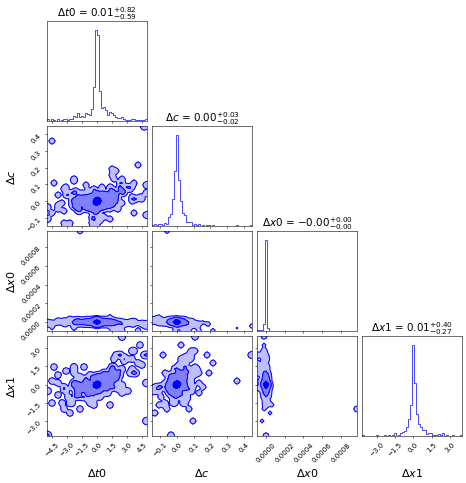

In [18]:
fig = plt.figure(figsize=(15,15),dpi=60)
_ = corner_(better_results,
    var_names=list(guess.keys()),
    labels=list(map(lambda x : r"$\Delta "+x+r"$", guess.keys())))
fig.suptitle('Erreur absolue sur les paramètres reconstruits', fontsize=18)
plt.savefig('../../../project/figures/Uchuu_reconstructed')

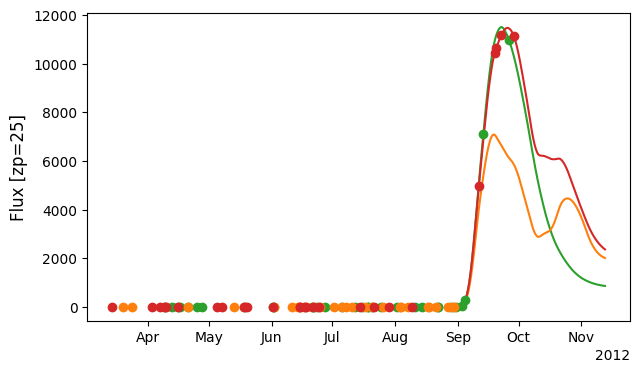

In [19]:
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x0"]==better_results['x0'].max()].index[0]])
